**DICOM to NifTI converter** - didn't work well (had to rerun on Linux computer)

This scrips uses dcm2niix (https://github.com/rordenlab/dcm2niix/releases) converter

In [2]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import nibabel
import numpy as np

import mne
from mne.io.constants import FIFF
from mne.transforms import apply_trans

%matplotlib qt

import pandas as pd
import numpy as np
import os


__________________

EXTRACT FILES FROM ARCHIVES

In [ ]:
import os
import tarfile

#! sub07 was faulty (had many subfolders in the archive), beeded manual extraction

# Base directory containing subject folders or archives
fs_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir'
groups = ["Y", "O"]

for group in groups:
    base_dir = os.path.join(fs_dir, group)

    # List all items in the directory
    for file_name in os.listdir(base_dir):
        if file_name != 's1_pac_sub07':

            # Construct the full file path
            file_path = os.path.join(base_dir, file_name)

            # Check for tar or zip archive
            if file_name.endswith('.tar') or file_name.endswith('.tar.gz'):
                sub_name = os.path.splitext(os.path.splitext(file_name)[0])[0]  # removes .tar/.gz
                # extract_dir = os.path.join(base_dir, sub_name)
                
                os.makedirs(base_dir, exist_ok=True)
                print(f'Extracting {file_name} to {base_dir}...')

                with tarfile.open(file_path, 'r') as tar:
                    tar.extractall(path=base_dir)

print('All archives processed.')


_____________________________

**Sanity check: visualisation of FS files**

In [67]:
# subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\fs'
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
subject = "s1_pac_sub01"
t1_fname = os.path.join(subjects_dir, subject, "mri", "T1.mgz")
t1 = nibabel.load(t1_fname)
t1.orthoview()

<OrthoSlicer3D: D:/BonoKat/research project/# study 1/mri_data/fs_output/freesurfer/sub_dir/Y/s1_pac_sub01/mri/T1.mgz (256, 256, 256)>

Traceback (most recent call last):
  File "d:\BonoKat\research project\motor_pac\venv\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
TypeError: OrthoSlicer3D._cleanup() takes 1 positional argument but 2 were given


In [ ]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    subject, hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)

__________________________________

CHECK BEM SURFACES

In [69]:
bem_path = os.path.join(subjects_dir, subject, 'bem', f"{subject}-head.fif")
surfaces = mne.read_bem_surfaces(bem_path)

    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read


In [70]:
import mne
from mne.datasets import fetch_fsaverage

# Try reading a cortical surface (e.g., lh.pial)
surf_path = f"{subjects_dir}/{subject}/surf/lh.pial"
coords, faces = mne.read_surface(surf_path)
print(f"✅ Surface loaded. Vertices: {len(coords)}, Faces: {len(faces)}")


✅ Surface loaded. Vertices: 134495, Faces: 268986


In [71]:
# Test a cortical surface
coords, faces = mne.read_surface(f"{subjects_dir}/{subject}/surf/lh.pial")
print(f"✅ lh.pial loaded: {len(coords)} vertices, {len(faces)} faces")

✅ lh.pial loaded: 134495 vertices, 268986 faces


_____________________

Reading electrode locations

In [159]:
dig_folder = 'D:\\BonoKat\\research project\\# study 1\\dig_data\\files for analysis\\Y'
subject = 's1_pac_sub01'
dig_file = os.path.join(dig_folder, f"{subject}.txt")

# Set the header line
column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

# Load the data, skipping the header lines
dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values

dig_points_df

,Electrode Name,Electrode Type,Loc. X,Loc. Y,Loc. Z
0,PZ,EEG,9.0000,-82.7433,84.9290
1,AF7,EEG,-52.6085,64.5538,15.0691
2,F5,EEG,-64.1519,38.7953,34.8584
3,C5,EEG,-82.0651,-18.4729,42.4110
4,POZ,EEG,5.3253,-106.0596,53.6421
...,...,...,...,...,...
59,PO8,EEG,57.7311,-97.7802,3.4139
60,P2,EEG,40.5271,-76.4376,78.4701
64,LPA,fiducial,139.3335,55.8965,-170.3642
65,Nasion,fiducial,23.6860,41.4335,-158.2550


In [160]:
import mne
import numpy as np


# Convert mm to m
dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

# EEG electrodes
eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
eeg_pos = dict(zip(
    eeg_df['Electrode Name'],
    np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
))

# Fiducials
fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
           for _, row in fid_df.iterrows()}

# Lowercase the montage keys to match MNE style
montage_renamed = {
    k.strip().capitalize(): v for k, v in eeg_pos.items()
}
# Create montage
montage = mne.channels.make_dig_montage(
    ch_pos=eeg_pos,
    # nasion=fid_pos['nasion'], # removed fducials, since they do not allign with the positions of the electrodes
    # lpa=fid_pos['lpa'],
    # rpa=fid_pos['rpa'],
    coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
)


In [152]:
fid_pos

{'lpa': [0.1433878, 0.0691741, -0.1649966],
 'nasion': [0.0285732, 0.0565072, -0.15959800000000002],
 'rpa': [0.053936, 0.17356069999999998, -0.1436328]}

In [161]:
epochs_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo.fif'
epochs = mne.read_epochs(epochs_file)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\s1_pac_sub01_MAIN_epochs_plan_baseline-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 15 columns
50 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [162]:
epochs.set_montage(montage, match_case=False)


<EpochsFIF | 50 events (all good), -0.5 – 0.5 s (baseline -0.5 – 0.5 s), ~11.7 MB, data loaded, with metadata,
 'target_on': 50>

In [163]:
epochs.info['dig']

[<DigPoint |        LPA : (-99.9, 0.0, 0.0) mm      : head frame>,
 <DigPoint |     Nasion : (0.0, 99.9, 0.0) mm       : head frame>,
 <DigPoint |        RPA : (99.9, 0.0, 0.0) mm       : head frame>,
 <DigPoint |     EEG #1 : (9.0, -82.7, 84.9) mm     : head frame>,
 <DigPoint |     EEG #2 : (-52.6, 64.6, 15.1) mm    : head frame>,
 <DigPoint |     EEG #3 : (-64.2, 38.8, 34.9) mm    : head frame>,
 <DigPoint |     EEG #4 : (-82.1, -18.5, 42.4) mm   : head frame>,
 <DigPoint |     EEG #5 : (5.3, -106.1, 53.6) mm    : head frame>,
 <DigPoint |     EEG #6 : (-85.9, -19.0, 6.9) mm    : head frame>,
 <DigPoint |     EEG #7 : (40.1, -102.6, 40.7) mm   : head frame>,
 <DigPoint |     EEG #8 : (36.9, 25.6, 79.0) mm     : head frame>,
 <DigPoint |     EEG #9 : (-71.7, -81.7, 10.5) mm   : head frame>,
 <DigPoint |    EEG #10 : (-49.2, 41.8, 56.4) mm    : head frame>,
 <DigPoint |    EEG #11 : (33.6, -114.2, 8.4) mm    : head frame>,
 <DigPoint |    EEG #12 : (-30.0, 81.9, 15.0) mm    : head fra

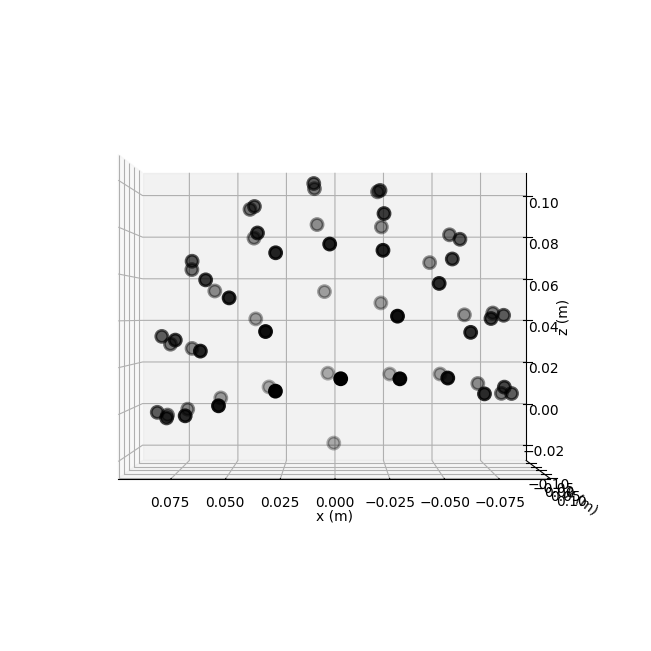

In [164]:
epochs.plot_sensors(kind='3d')

In [165]:
epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_15860\2535045416.py:1: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\s1_pac_sub01_MAIN_epochs_plan_baseline-epo_montage.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)


In [ ]:
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
info = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif'
mne.gui.coregistration(subject=subject,
                       subjects_dir=subjects_dir,
                       inst=info,
                       )


PLOT BEM SURFACES

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


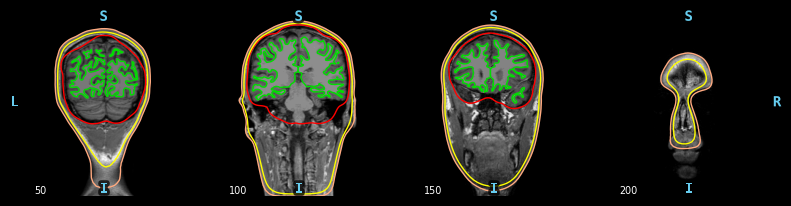

In [167]:
plot_bem_kwargs = dict(
    subject=subject,
    subjects_dir=subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)

mne.viz.plot_bem(**plot_bem_kwargs)

CHECK COREGISTRATION

In [176]:
info = epochs.info
trans_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\preproc\\analysis\\{subject}-trans.fif'
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info,
    trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=subjects_dir,
    surfaces=["head"],
)

Using outer_skin.surf for head surface.
Channel types::	eeg: 60


COMPUTE SOURCE SPACE

In [186]:
src = mne.setup_source_space(
    subject, spacing="ico4", add_dist="patch", subjects_dir=subjects_dir
)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y
Subject      = s1_pac_sub01
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\surf\lh.white...
Mapping lh s1_pac_sub01 -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/134495 selected to source space (ico = 4)

Loading D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\surf\rh.white...
Mapping rh s1_pac_sub01 -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\BonoKat\re

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


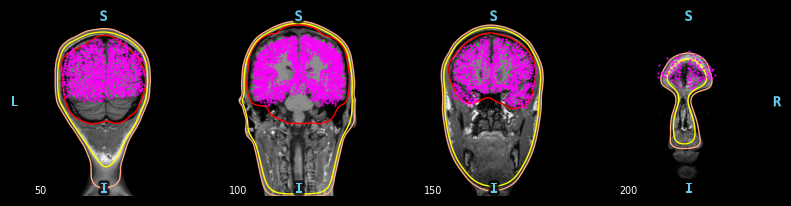

In [187]:
mne.viz.plot_bem(src=src, **plot_bem_kwargs)

Boundary surface file : D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\mri\T1.mgz

Reading D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\mri\T1.mgz...

Loaded bounding surface from D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf (10242 nodes)
Surface CM = (   0.6  -26.8   37.8) mm
Surface fits inside a sphere with radius   96.6 mm
Surface extent:
    x =  -70.2 ...   71.0 mm
    y = -112.9 ...   69.6 mm
    z =  -37.2 ...  107.4 mm
Grid extent:
    x =  -75.0 ...   75.0 mm
    y = -115.0 ...   70.0 mm
    z =  -40.0 ...  110.0 mm
36518 sources before omitting any.
26784 sources after omitting infeasible sources not within 0.0 - 96.6 mm.
Sour

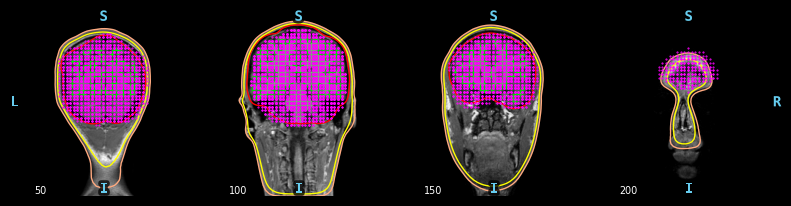

In [190]:
surface = os.path.join(subjects_dir, subject, "bem", "inner_skull.surf")
vol_src = mne.setup_volume_source_space(
    subject, subjects_dir=subjects_dir, surface=surface, add_interpolator=False
)  # Just for speed!
print(vol_src)

mne.viz.plot_bem(src=vol_src, **plot_bem_kwargs)

In [ ]:
fig = mne.viz.plot_alignment(
    subject=subject,
    subjects_dir=subjects_dir,
    surfaces="white",
    coord_frame="mri",
    src=src,
)
mne.viz.set_3d_view(
    fig,
    azimuth=173.78,
    elevation=101.75,
    distance=0.30,
    focalpoint=(-0.03, -0.01, 0.03),
)

In [193]:
# conductivity = (0.3,)  # for single layer
conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(
    subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir
)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is   0.04 -23.83  28.54 mm
outer skull CM is   0.02 -23.69  28.01 mm
inner skull CM is   0.56 -26.75  37.77 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.7 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    1.3 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
     

In [194]:
bem

<ConductorModel | BEM (3 layers) solver=mne>

In [200]:
fwd = mne.make_forward_solution(
    info,
    trans=trans,
    src=src,
    bem=bem,
    eeg=True,
    n_jobs=-1,
    # verbose=True,
)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] MRI (surface RAS) coords, subject 's1_pac_sub01', ~25.3 MB>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.998062 0.057496 0.023814       2.69 mm
    -0.057383 0.998338 -0.005378      -1.33 mm
    -0.024083 0.004001 0.999702     -18.13 mm
    0.000000 0.000000 0.000000       1.00

Read  60 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


Setting up for EEG...
Computing EEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.



Finished.
<Forward | MEG channels: 0 | EEG channels: 60 | Source space: Surface with 5124 vertices | Source orientation: Free>


[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


In [202]:
print(f"Before: {src}")
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] MRI (surface RAS) coords, subject 's1_pac_sub01', ~25.3 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] head coords, subject 's1_pac_sub01', ~25.3 MB>


In [203]:
leadfield = fwd["sol"]["data"]
print(f"Leadfield size : {leadfield.shape[0]} sensors x {leadfield.shape[1]} dipoles")

Leadfield size : 60 sensors x 15372 dipoles


In [204]:
fwd_fixed = mne.convert_forward_solution(
    fwd, surf_ori=True, force_fixed=True, use_cps=True
)
leadfield = fwd_fixed["sol"]["data"]
print(f"Leadfield size : {leadfield.shape[0]} sensors x {leadfield.shape[1]} dipoles")

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 60 sensors x 5124 dipoles


In [218]:
noise_cov = mne.compute_covariance(epochs, tmax=0, method='empirical', rank=None) # method='empirical' for optimal regularisation
noise_cov.plot(epochs.info)

    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 12550
[done]
Computing rank from covariance with rank=None
    Using tolerance 1e-13 (2.2e-16 eps * 60 dim * 7.8  max singular value)
    Estimated rank (eeg): 54
    EEG: rank 54 computed from 60 data channels with 0 projectors


(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 1e-13 (2.2e-16 eps * 60 dim * 7.8  max singular value)
    Estimated rank (eeg): 54
    EEG: rank 54 computed from 60 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank={'eeg': 54}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 54 (6 small eigenvalues omitted)


C:\Users\a1902989\AppData\Local\Temp\ipykernel_15860\1975728939.py:2: RuntimeWarning: The largest eigenvalue of the 60-channel eeg covariance (rank=54) is over 10 orders of magnitude larger than the smallest (7.83e-10 > 1e10 * 4.68e-21), the resulting whitener will likely be unstable
  evoked.plot_white(noise_cov, time_unit="s")


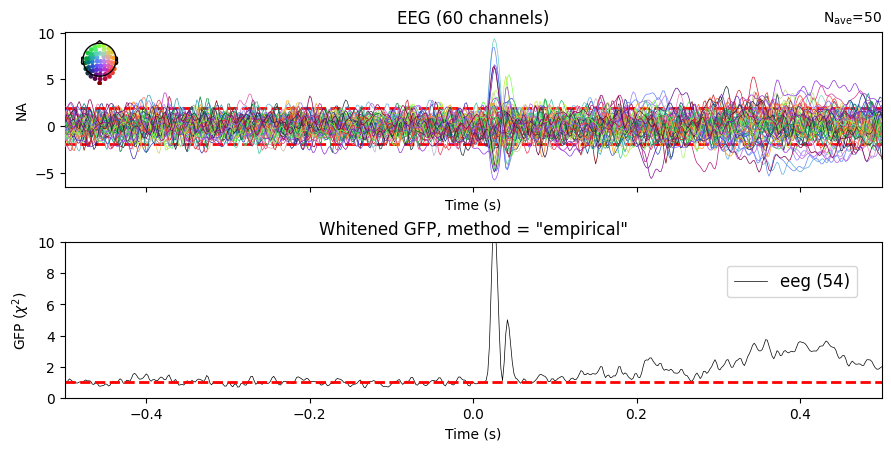

In [219]:
evoked = epochs.average()
evoked.plot_white(noise_cov, time_unit="s")

______________________

In [142]:
trans = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\preproc\\analysis\\s1_pac_sub01-trans'